In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats

In [4]:
from feature_extraction_helper import compute_laterality,reshape_feature_array, tail_oscillations_with_laterality

## Load data

In [5]:
master_path = Path(Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Koetter-et-al_data\Testdata') / 'Raw_Data')
out_path = Path(master_path/'Processed_Data')
fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths

[WindowsPath('//portulab.synology.me/data/Kata/Figures_Paper/Koetter-et-al_data/Testdata/Raw_Data/240423_f0')]

In [6]:
fish= 0
fish_id =  fish_paths[fish].name
exp_name = 'testfish'
fish_id, exp_name


('240423_f0', 'testfish')

In [7]:
save_data_path = out_path

In [8]:
t_feature_vector_array = fl.load(save_data_path/ '{}_t_feature_vector_array.h5'.format(fish_id))
l_feature_vector_array = fl.load(save_data_path/ '{}_l_feature_vector_array.h5'.format(fish_id))
r_feature_vector_array = fl.load(save_data_path/ '{}_r_feature_vector_array.h5'.format(fish_id))

In [9]:
## tail, left fin, right fin

traces =  fl.load(out_path / '{}_tensor.h5'.format(fish_id))
traces.shape

(460, 3, 50)

### Get the number of peaks for all tails

    Note - we have to take the directionality into acocunt 

In [10]:
max_n = int(l_feature_vector_array.shape[1]/4)
max_n

9

In [11]:
t_reshaped_array, t_peaks_a_array, t_peaks_i_array, t_valleys_a_array, t_valleys_i_array = reshape_feature_array(t_feature_vector_array)
l_reshaped_array, l_peaks_a_array, l_peaks_i_array, l_valleys_a_array, l_valleys_i_array = reshape_feature_array(l_feature_vector_array)
r_reshaped_array, r_peaks_a_array, r_peaks_i_array, r_valleys_a_array, r_valleys_i_array = reshape_feature_array(r_feature_vector_array)


Reshaped array shape: (460, 4, 9)
Reshaped array shape: (460, 4, 9)
Reshaped array shape: (460, 4, 9)


### Assess laterality of tail

Laterality: left


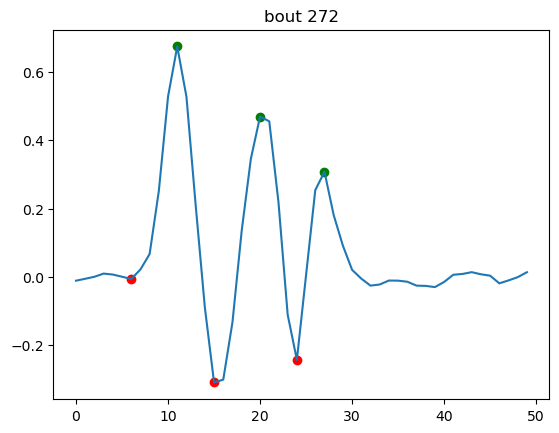

In [12]:
data = traces[:,0,:]
bout = np.random.randint(0,data.shape[0])

plt.figure()
plt.plot(data[bout, :])
plt.scatter(t_peaks_i_array[bout], t_peaks_a_array[bout], c='green')
plt.scatter(t_valleys_i_array[bout], t_valleys_a_array[bout], c='red')
plt.title('bout {}'.format(bout))

# Access the first row of each array
peaks_first = t_peaks_a_array[bout, 0]
valleys_first = t_valleys_a_array[bout, 0]

# Compare and determine laterality
laterality = np.where( np.abs(peaks_first) > np.abs(valleys_first), 'left', 'right')

print("Laterality:", laterality)


In [25]:
laterality = fl.load(out_path/ '{}_bout_laterality.h5')

In [26]:
t_osc = tail_oscillations_with_laterality(t_peaks_a_array, t_valleys_a_array, laterality)

print("Total non-NaN counts per row based on laterality:", np.unique(t_osc))


Total non-NaN counts per row based on laterality: [1. 2. 3. 4. 5. 6. 7.]


### Extract oscillations fins

### Filter peaks below a certain hight

In [27]:
mask  = r_peaks_a_array <= 0.1
print(len(mask))
r_peaks_a_array[mask] = np.nan

460


In [28]:
mask  = l_peaks_a_array <= 0.1
print(len(mask))
l_peaks_a_array[mask] = np.nan

460


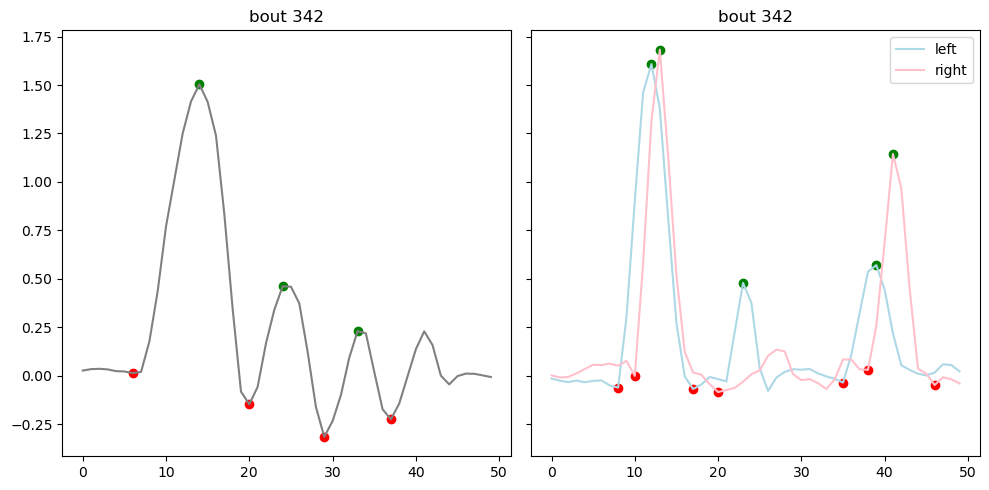

In [29]:
bout = np.random.randint(0,traces.shape[0])

fig, axes = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.ravel()
axes[0].plot(traces[bout,0,:], c='gray', label='tail')
axes[0].scatter(t_peaks_i_array[bout], t_peaks_a_array[bout], c='green')
axes[0].scatter(t_valleys_i_array[bout], t_valleys_a_array[bout], c='red')
axes[0].set_title('bout {}'.format(bout))

axes[1].plot(traces[bout,1,:]*-1, c='lightblue', label='left')
axes[1].scatter(l_peaks_i_array[bout], l_peaks_a_array[bout], c='green')
axes[1].scatter(l_valleys_i_array[bout], l_valleys_a_array[bout], c='red')

axes[1].plot(traces[bout,2,:], c='pink', label='right')
axes[1].scatter(r_peaks_i_array[bout],r_peaks_a_array[bout], c='green')
axes[1].scatter(r_valleys_i_array[bout], r_valleys_a_array[bout], c='red')
axes[1].set_title('bout {}'.format(bout))

plt.legend()
plt.tight_layout()

#### Count peaks

In [30]:
# Count non-NaN entries per row
l_osc = np.sum(~np.isnan(l_peaks_a_array), axis=1)
# Count non-NaN entries per row
r_osc = np.sum(~np.isnan(r_peaks_a_array), axis=1)

print("Number of non-NaN elements per row:", np.unique(l_osc))
print("Number of non-NaN elements per row:", np.unique(r_osc))

np.where(l_osc==0)

Number of non-NaN elements per row: [0 1 2 3 4 5 6 7 8 9]
Number of non-NaN elements per row: [0 1 2 3 4 5 6 7 8]


(array([ 29, 116, 304, 362], dtype=int64),)

## Save data

In [31]:
fl.save(save_data_path/ '{}_oscillations.h5'.format(fish_id), [t_osc, l_osc, r_osc])

In [32]:
laterality.shape

(460,)